In [1]:
# Math imports
import math
import numpy as np
import numba as nb
from sympy import *

# Typing imports (NamedTuple may not be necessary if I refactor)
import warnings

# Combinatorics and data imports
import itertools
import data.DataGenerator as dg

# Auxiliary/visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('figstyle.mplstyle')

# Please use the requirements_dev.txt to load dependencies for this code.

Let's consider the *logistic map*,

$$x_{n+1}=rx_{n}(1-x_{n}),$$

with $r = 4$. This value has already been set as the default parameter.

$r = 4$ enables chaotic behavior over the entire range [0, 1], and the Lyapunov exponent $\lambda$ for the logistic map at $r = 4$ can be computed precisely, $\lambda = log(2)$. 

In [2]:
# Let's initialize a series of 2D dynamical systems governed by the Duffing oscillator equation using DataGenerator.
# Each of m_traj trajectories contains m timesteps in n = 2 dimensions. 
# This creates a large dataset that is a concatenation of trajectories X.

n = 1
m = 1001
m_traj = 100

X0 = np.random.uniform(low = 0, high = 1.0, size = (n, m_traj))
Xk = np.zeros((n, m_traj * m))
Xkplus1 = np.zeros((n, m_traj * m))

generator = dg.DataGenerator(X0[:,0], num_steps = m, mapname = "logisticmap", r = 4)

for i in range(m_traj):
    Xi = generator.generate_series(X0[:,i], num_steps = m).T
    Xk[:, i * m : (i+1) * m - 1] = Xi[:, 0:m-1]
    Xkplus1[:, i * m : (i+1) * m - 1] = Xi[:, 1:m]
    

/var/folders/pq/1yd98dcd4v5_68_nxtvz_vhm0000gn/T/ipykernel_63558/4005652199.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Xk[0, i * m : (i+1) * m - 1], Xkplus1[0, i * m: (i+1) * m - 1], s=2, c = colors[i])


Text(0.5, 1.0, '2D trajectories of Duffing oscillator, phase space')

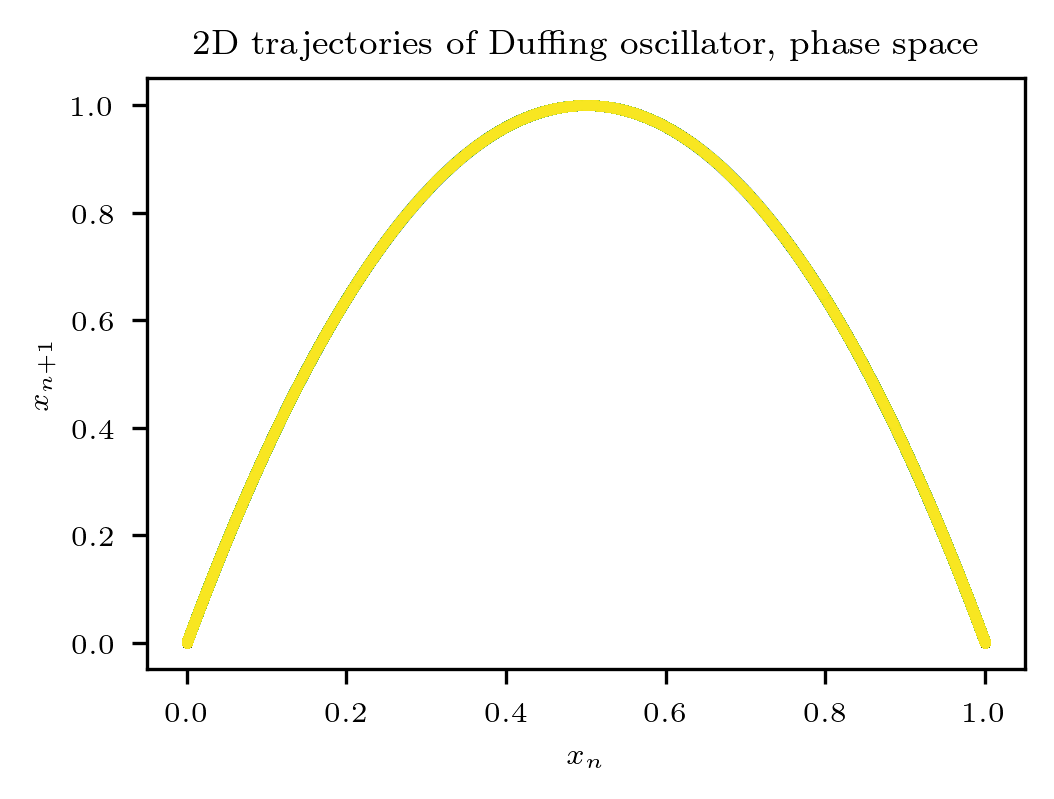

In [3]:
# Let's visualize a couple of trajectories for the sake of example

cm = plt.get_cmap('viridis')
colors = [cm(i/m_traj) for i in range(m_traj)]
 
fig, ax = plt.subplots()
for i in range(m_traj):
    ax.scatter(Xk[0, i * m : (i+1) * m - 1], Xkplus1[0, i * m: (i+1) * m - 1], s=2, c = colors[i])
ax.set(xlabel=r'$x_{n}$', ylabel=r'$x_{n+1}$')
ax.set_title("2D trajectories of Duffing oscillator, phase space")

In [4]:
# Set up dictionary of basis functions
# For now, we will use polynomials up to order max_deg = 3
# I chose to avoid use of numpy.polynomial.hermite and/or hermite_e for downstream flexibility of basis function composition

# Number of dictionary entries
# is equivalent to len(basis_fns) if we are constructing basis functions via monomial combinatorics as below
def getDimPsi(n, max_deg):
    dim_Psi = 1
    for i in range(1, max_deg + 1):
        dim_Psi += math.factorial(n + i - 1) / (math.factorial(i) * math.factorial(n - 1))

    return int(dim_Psi)

# Create library of monomial basis functions up to order max_deg
# Uses sympy for interpretability, convert to Numpy function using sympy.lambdify() at runtime
def createBasis(n, max_deg):
    
    symstring = ''
    for i in range(n):
        symstring += f'x{i+1},'
    pv = symbols(symstring) # define list of symbols as x1, x2, ... xn (dimensionality n).

    # Generate list of dictionary keys, which are tuples representing the type and multiplicity of symbols (\in pv) in each monomial
    keys = [(1,)]
    for i in range(1, max_deg + 1):
        keys += list(itertools.combinations_with_replacement(pv, i))

    basis_fns = dict.fromkeys(keys, None)

    for key in keys:
        basis_fns[key] = Lambda(pv, math.prod(key))

    return basis_fns, len(basis_fns) # getDimPsi(n, max_deg)

In [5]:
# Verify the construction of the monomial library
polybasis = createBasis(n, max_deg = 3)
print(polybasis)

({(1,): Lambda(x1, 1), (x1,): Lambda(_x, _x), (x1, x1): Lambda(x1, x1**2), (x1, x1, x1): Lambda(x1, x1**3)}, 4)


In [6]:
# Here, I define a series of functions that will be used in approximating the action of the Koopman operator via finite matrix K
# Tlsq and svd are 'redefined' here to create easy interfaces for truncation, when data is noised

# Compute truncated least squares, for later signal-noise thresholding
# Derived from source for PyDMD (RTD: pydmd.github.io)
# 
# Take X and Y, perform SVD -> get V, truncate up to rank, take Hermitian transpose, and take VtV as the
# square, symmetric matrix representing the dot product of the columns of V. (t denotes Hermitian conjugate).
# Note that V (as in U, S, V) computed by np.linalg.svd is unitary; taking VtV returns I, but truncating
# V prior to Vt and VtV destroys the unitarity of this matrix and returns a nontrivial result. Return 
# X dot VtV and Y dot VtV as the truncated/denoised series X and Y. 
# 
def compute_tlsq(X: np.ndarray, Y: np.ndarray, tlsq_rank: int
                ):
    
    # Do not perform tlsq if desired rank is 0
    if tlsq_rank == 0: return X, Y

    V = np.linalg.svd(np.append(X, Y, axis = 0), full_matrices = False)[-1]
    rank = min(tlsq_rank, V.shape[0])
    VV = V[:rank, :].conj().T.dot(V[:rank, :])

    return X.dot(VV), Y.dot(VV)

# Compute singular value hard threshold
# Derived from source for PyDMD (RTD: pydmd.github.io)
# 
# References:
# Gavish, Matan, and David L. Donoho, The optimal hard threshold for
# singular values is, IEEE Transactions on Information Theory 60.8
# (2014): 5040-5053.
# https://ieeexplore.ieee.org/document/6846297
# 
def compute_svht(s: np.ndarray, rows: int, cols: int) -> int:

    beta = np.divide(*sorted((rows, cols)))
    omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    tau = np.median(s) * omega
    rank = np.sum(s > tau)

    if rank == 0:
        warnings.warn("SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.", RuntimeWarning)
        rank = 1

    return rank

# Compute rank for truncated SVD
# Derived from source for PyDMD (RTD: pydmd.github.io)
# 
# References:
# Gavish, Matan, and David L. Donoho, The optimal hard threshold for
# singular values is, IEEE Transactions on Information Theory 60.8
# (2014): 5040-5053.
# https://ieeexplore.ieee.org/document/6846297
# 
def compute_rank(s: np.ndarray, rows: int, cols: int, svd_rank: int) -> int:
    
    if svd_rank == 0:
        rank = compute_svht(s, rows, cols)
    elif 0 < svd_rank < 1:
        cumulative_energy = np.cumsum(s**2 / (s**2).sum())
        rank = np.searchsorted(cumulative_energy, svd_rank) + 1
    elif svd_rank >= 1 and isinstance(svd_rank, int):
        rank = min(svd_rank, s.size)
    else:
        rank = min(rows, cols)

    return rank
        
# Compute truncated SVD
# Derived from source for PyDMD (RTD: pydmd.github.io)
# 
# I will not document this as you know what's going on
def compute_svd(X: np.ndarray, svd_rank: int = 0
               ):
    
    U, s, V = np.linalg.svd(X, full_matrices = False)
    rank = compute_rank(s, X.shape[0], X.shape[1], svd_rank)
    V = V.conj().T

    U = U[:, :rank]
    V = V[:, :rank]
    s = s[:rank] # 1D vector, use np.diag(s) to place on diagonal

    return U, s, V

# Build dictionary function Psi(X) using the basis; i.e., evaluate all basis functions at Xk for each timestep k.
#
# This generates the polynomial (or other basis) feature matrix, consisting (in this case) of all
# polynomial combinations of the features X with degree less than or equal to max_deg.
# 
# @nb.njit(fastmath=True)
def Psi(X, basis, dimPsi):

    n = X.shape[0]
    m = X.shape[1]

    PsiX = np.zeros((dimPsi, m), dtype = np.float64)
    for k in range(m):
        # For each timestep k, take all basis functions fn in basis and evaluate at unpacked n-dimensional state coords X[:,k]
        PsiX[:, k] = [fn(*X[:, k]) for key, fn in basis.items()]

    return PsiX

In [7]:
# Now, approximate the Koopman operator via EDMD. We sequentially transform the measured
# state data X, Y, first lifting it into observation space (via the action of the polynomial basis),
# then denoising lifted data if necessary (not performed here; tlsq_rank = 0, svd_rank = 1),
# then performing the EDMD routine via SVD to generate:
#
# K: finite approximation of Koopman operator governing evolution of observables in lifted space, i.e., state transition matrix.
# eigenvalues, eigenvectors: The eigenvalues and right eigenvectors of the state matrix K. 
# U: contains the eigenvectors of KKt (t is Hermitian conjugate) as columns, used for projecting states
# up to the lifted observable space (via x @ U.conj() ) then back down to state space (via xlift @ K.T @ U.T)
# unnormalized_modes: Koopman modes, i.e., stable modes of the dynamics induced by the action of K
# compute_psi: transformation matrix to compute fitted basis fns Psi at given coordinates

max_deg = 3
tlsq_rank = 0   # Default value
svd_rank = 1.0  # Default value

# Lift the data
basis, dimPsi = createBasis(n, max_deg)
PsiX = Psi(Xk, basis, dimPsi)
PsiY = Psi(Xkplus1, basis, dimPsi)

##### This is a previous (as of writing, 10/15) subroutine to compute the K, which is similar to what's happening here but seemed wrong
#
# Compute K
# Use Moore-Penrose pseudo-inverse, instead of matrix inversion, for the general case
# A rcond threshold is set for numerical stability/interpretability according to Numerical Recipes, pg. 795. 2e-16 is machine error
# threshold for np.float64 dtype. 
# 
# K = np.linalg.pinv(PsiX @ PsiX.conj().T, rcond = n * 2e-16) @ PsiX @ PsiY.conj().T
#
#####

##### This is a current (as of writing, 10/15) subroutine to compute the K and other goodies
X1T, X2T = compute_tlsq(PsiX, PsiY, tlsq_rank) # with tlsq_rank = 0, X1T = PsiX.T and X2T = PsiY.T
U, s, V = compute_svd(X1T, svd_rank)

K = U.conj().T @ X2T @ V @ np.diag(np.reciprocal(s))
eigenvalues, eigenvectors = np.linalg.eig(K)
unnormalized_modes = U @ eigenvectors
compute_psi = np.linalg.inv(eigenvectors) @ U.conj().T

##### I was never sure what this was supposed to do, it was constructing "projection operator"
# 
# nPsi = 18 # getDimPsi(n, max_deg)
# B = np.zeros((n, nPsi), dtype = np.float64)
# # Should investigate why the following two lines are present in the Julia codebase
# B[0, 2] = 1.0 # This looks like B enables a projection onto x2, given the above basis; does this map x1 -> x2?
# B[1, 1] = 1.0 # This looks like B enables a projection onto x1, given the above basis; does this map x2 -> x1? 
# 
#####
                       

Text(0.5, 1.0, '$U^{*}KU^T$')

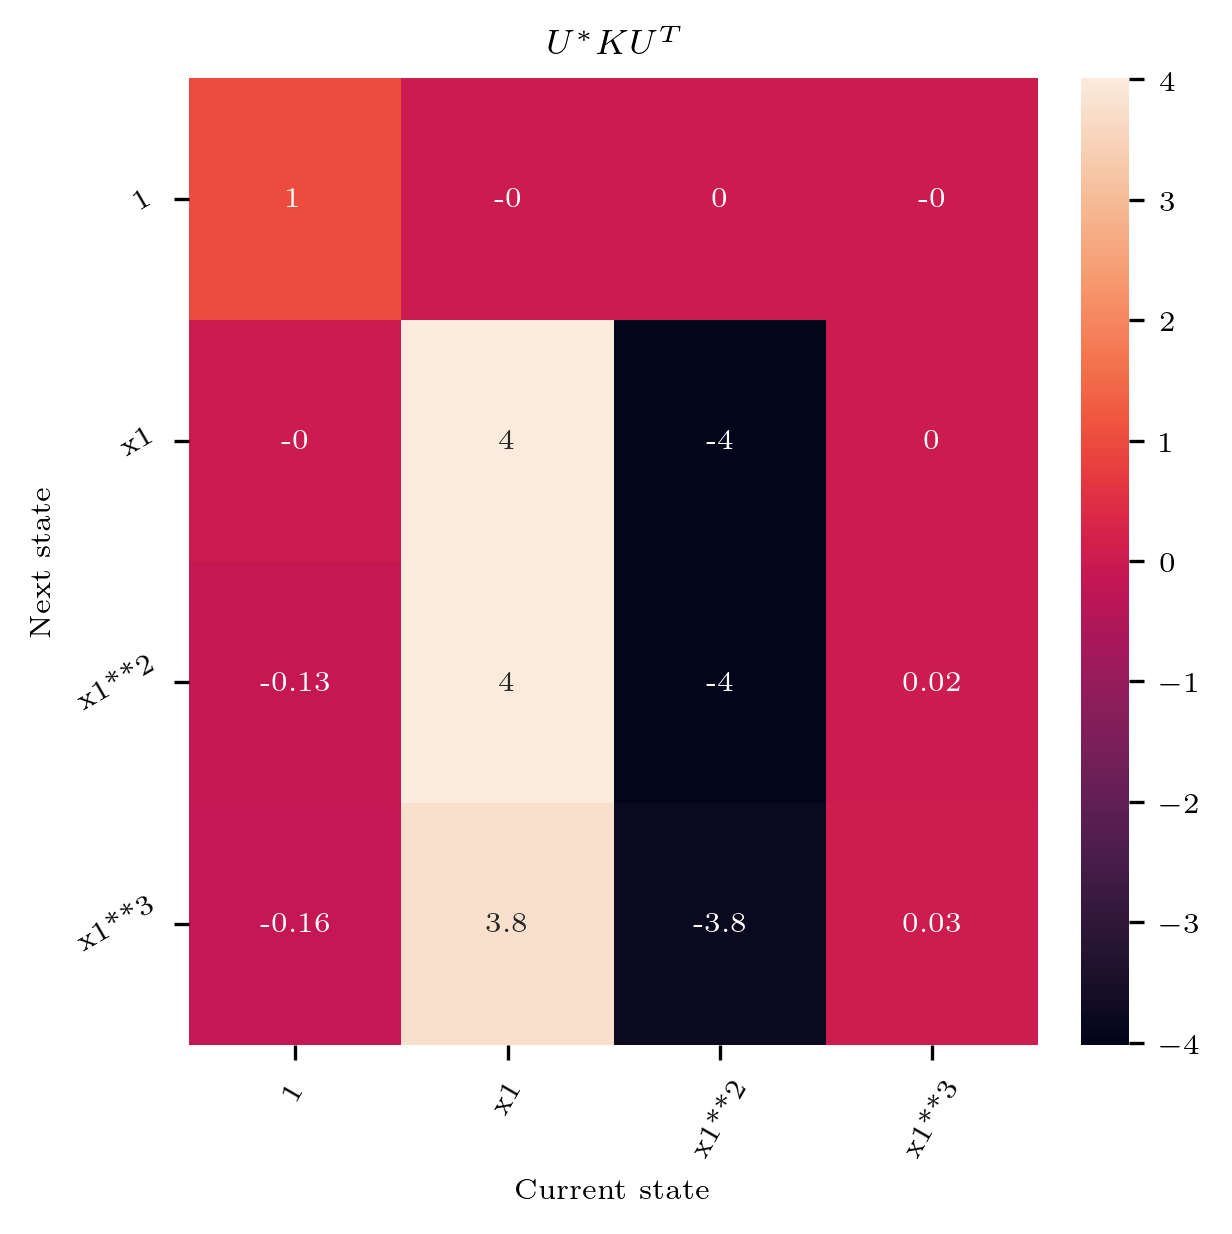

In [8]:
# Plot heatmap of absolute values of approximate Koopman operator K
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(np.around(U.conj() @ K @ U.T, 2), ax=ax, annot=True)
# sns.heatmap(np.around(K, 2), ax=ax, annot=True)
labels = [prod(key) for key, fn in polybasis[0].items()]
ax.set_xticklabels(labels, rotation=60)
ax.set_yticklabels(labels, rotation=30)
ax.set(xlabel="Current state", ylabel="Next state")
ax.set_title(r"$U^{*}KU^T$")

With the 1D logistic map case, we can see that we've constructed a forward map from state to state:
$$x_{n+1}=rx_{n}(1-x_{n}), r=4$$
$$\therefore x_{n+1} = 4x_{n} - 4x_{n}^2$$
where the next state $x1$ on the y-axis is dependent on some terms $x1$, $x1^2$, $x1^3$ nonlinearly transforming the current state.

With the map case, unlike the time-dependent ODE shown in the 2D_Duffing case (which requires computing $\left[(U^*KU^{T})-I_{\text{dimPsi}}\right]/dt$ to effectively recover the first-time-derivative RHS), the components of U*KU^T directly recover the form of the map. 

Text(0.5, 1.0, '$Re(\\lambda)$ heatmap')

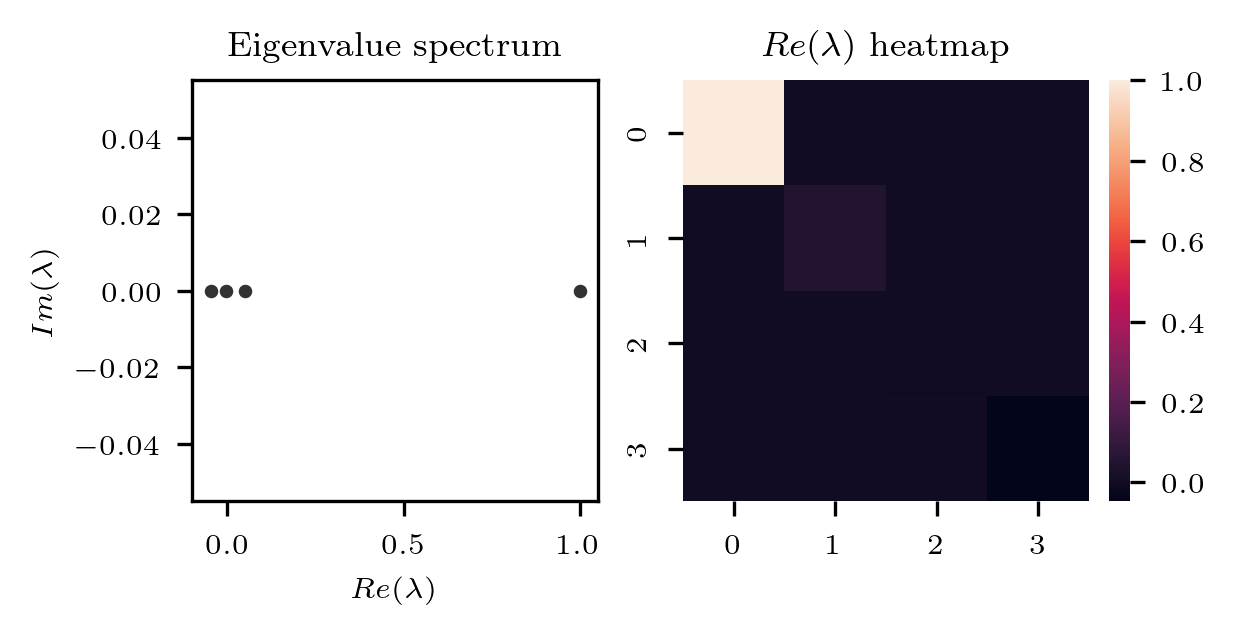

In [9]:
# Ignore warnings as discarding the complex component of eigenvals will raise a warning
import warnings
warnings.filterwarnings('ignore')

# Sort the eigendecomposition of the Koopman operator
eigenvals_real_component = np.real(eigenvalues)

# Some sorting, by the real component of the eigenvalues; descending order
eigenvals = np.array([x for _, x in sorted(zip(eigenvals_real_component, eigenvalues), key = lambda pair: pair[0])], dtype = np.complex128)[::-1]
eigenvecs = np.array([x for _, x in sorted(zip(eigenvals_real_component, eigenvalues), key = lambda pair: pair[0])], dtype = np.complex128)[::-1]

# Visualize the eigenvalue spectrum
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].scatter(np.real(eigenvals), np.imag(eigenvals), s = 5)
ax[0].set(xlabel=r'$Re(\lambda)$', ylabel=r'$Im(\lambda)$')
ax[0].set_title("Eigenvalue spectrum")

sns.heatmap(np.diag(np.real(eigenvals)), ax=ax[1])
ax[1].set_title(r'$Re(\lambda)$ heatmap')


In [10]:
# Compute the Koopman eigenfunctions and evaluate on an equidistant grid

lb, ub = 0, 1
nsamples = 101
xx = np.zeros((n, nsamples))
xx[0] = np.linspace(lb, ub, nsamples)
grid_coord = xx

phi_max = 20

# To plot eigenfunctions in the same phase space as the example trajectories above:

# Lift states (grid coordinates) to space of observables
liftgrid = Psi(grid_coord, basis, dimPsi).T 

# Evaluate the eigenfunctions at each lifted state, by left-multiplying by inv(eigenvectors) @ U.conj().T
# In effect, we take the lifted states y, left-multiply by U.conj().T (with U serving as the projection
# matrix constructed during SVD of X1T), and then left-multiply by the inverse of eigenvector matrix
# (which provides coordinates of these state vectors in the basis spanned by the eigenvectors).
# compute_psi = np.linalg.inv(eigenvectors) @ U.conj().T, as stated above.
psi_grid = (compute_psi @ liftgrid.T).T

# This is here in case we want to normalize vectors and explicitly state their true ranges
def vecnorm(x, lb = 0.001):
    dx = np.max(x) - np.min(x)
    return ((((x - np.min(x)) / dx) + lb) / (1 + lb)), np.min(x), np.max(x)


[Text(0, 0.5, '$\\Im({\\phi})$')]

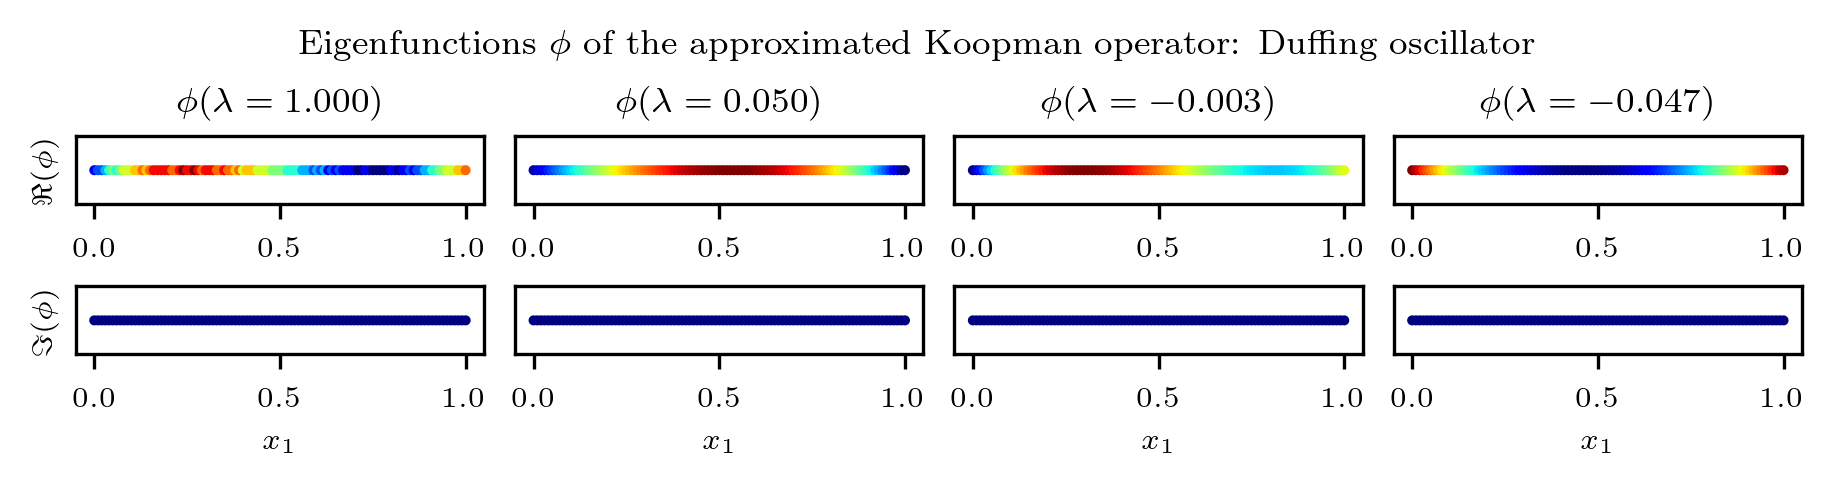

In [11]:
# Plot each eigenfunction phi, corresponding to each eigenvalue, evaluated on grid

plot_order = np.argsort(eigenvals_real_component)[::-1]

fig, ax = plt.subplots(2, dimPsi, figsize = (dimPsi*1.5, n*1.5))
fig.suptitle(r"Eigenfunctions $\phi$ of the approximated Koopman operator: Duffing oscillator")

for j in range(dimPsi):
    ax[0][j].scatter(grid_coord[0,:], np.zeros(nsamples), s=2, c=np.real(psi_grid[:,plot_order[j]]), cmap = 'jet')
    ax[1][j].scatter(grid_coord[0,:], np.zeros(nsamples), s=2, c=np.imag(psi_grid[:,plot_order[j]]), cmap = 'jet')
    ax[0][j].set_title(rf'$\phi(\lambda = {eigenvalues[plot_order[j]]:2.3f})$')
    ax[1][j].set(xlabel=r'$x_1$')
    ax[0][j].set_yticks([])
    ax[1][j].set_yticks([])

ax[0][0].set(ylabel=r'$\Re({\phi})$')
ax[1][0].set(ylabel=r'$\Im({\phi})$')

# for i in range(9):
#     for j in range(2): 
#         k = i * 2 + j
#         # vnorm, lb, ub = vecnorm(phi[:, :, k])
#         ax[i][j].scatter(grid_coord[0,:], grid_coord[1,:], s = 5, c = , cmap = 'viridis')
#         ax[i][j].set_title(rf'$\phi(\lambda = {np.around(np.real(eigenvals[k]), 2)} + {np.around(np.imag(eigenvals[k]), 2)}i) \in [{np.around(lb,2)}, {np.around(ub,2)}]$')
#         ax[i][j].set(xlabel=r'$x_1$', ylabel=r'$x_2$')

In [12]:
# Estimate prediction accuracy of the approximated Koopman operator on multiple trajectories
# 
# In other words, this is the coherent sequential code for taking an arbitrary state, lifting it to the observable space,
# advancing the system state one step (some implicit dt here) in the observable space using the approximated Koopman operator K,
# then inverting the lifting function to project the advanced state in the observable basis back down to the original state-vector basis. 
# 
# One should be careful about constructing the measurement matrix seen in this code, by the way. I was looking at an earlier Julia
# implementation that constructed this measurement matrix as some matrix B and manually populated it with B[0,2] = 1, B[1,1] = 1,
# and B[i,j] = 0 for all other i,j. It was bizarre. Taking the 0th slice of the polynomial basis to be unity, and 1 = x1, 2 = x2,
# we see that this Julia measurement matrix B was... mapping x2 -> x1 and x1 -> x2? Genuinely not sure what was going on. 
# 
# Further, the measurement matrix (let's call it C here) is intended to satisfy x = C * phi_r, i.e., a true measurement matrix
# should be C = measurement_matrix @ U. I'm still working on figuring this one out (on which vector, state or lifted, would you apply C?)

m_traj_test = 1000  # Number of trajectory samples m_traj
m_test = 101        # Number of timepoints per trajectory m

# Create analytical trajectories with random initial conditions
X0 = np.random.uniform(low = 0.0, high = 1.0, size = (n, m_traj_test))
X_test = np.zeros((n, m_test, m_traj_test))

for i in range(m_traj_test):
    
    # This is the analytical forward mapping: use the known governing equations to take the initial states
    # and map them forward for m_test steps for each of m_traj_test trajectories. 
    
    X_test[:, :, i] = generator.generate_series(X0 = X0[:, i], num_steps = m_test).T

# Construct the measurement matrix given dimensionality information about our data X_test and our polynomial basis.
# The construction X_test[:,:,0].T.shape[1] is confusing; as you can see above, this is simply retrieving the value n.
# In fact, x.T.shape[1] for some x having two dimensions is equivalent to x.shape[0], lol. 
# I've kept it complex here to be flexible and generalizable, but really, this is not necessary; n is defined anyway. 

measurement_matrix = np.zeros([X_test[:,:,0].T.shape[1], dimPsi])
measurement_matrix[:, 1 : 1 + X_test[:,:,0].T.shape[1]] = np.eye(X_test[:,:,0].T.shape[1])

# Set up trajectory prediction subroutine. We will do something difficult here: taking X_test[k] with 0..k..m_test for each trajectory,
# we will steal the initial conditions from each X_test and iteratively lift, advance via K, and down-project... for each step k in m_test.
# We then have two sets of trajectories, one analytically mapped and one approximately mapped, respectively X_test and XK_test.
# We will perform a direct coordinate comparison on the original state-vector basis at each timestep k (beside the initial condition)
# and compute RMS error per step to evaluate how well our approximated Koopman operator captures the analytical governing equations. 

XK_test = np.zeros((n, m_test, m_traj_test)) # Stores the predicted state vectors, down-projected from the observable space 

for i in range(m_traj_test):
    
    XK_test[:, 0, i] = X_test[:, 0, i] # "Load initial condition from analytical trajectory i into the first state of XK_test"

    # Advance dynamics via approximated Koopman operator
    for j in range(m_test - 1):

        # Including my interpretation of J Nathan Kutz and coworkers' PyKoopman library here, for reference / in case debug later.
        # pykoopman.Koopman.predict() takes state vector x and maps it one timestep forward using K, by invoking pykoopman.Koopman._step().

        xji = np.expand_dims(XK_test[:, j, i], axis = 1)

        # equivalent to pykoopman.Koopman._step() invoking pykoopman.BaseObservables.transform() on XK_test[whatever]
        XK_j_lift = Psi(xji, basis, dimPsi).T
        # equivalent to pykoopman.Koopman._step() invoking pykoopman.EDMD.predict() on XK_j_lift
        XK_jplus1_lift = XK_j_lift @ U.conj() @ K.T @ U.T
        # equivalent to pykoopman.Koopman.predict() invoking pykoopman.BaseObservables.inverse() on XK_jplus1_lift
        XK_jplus1_down = XK_jplus1_lift @ measurement_matrix.T

        # Now, populate the predicted XK_test with the approximated next step from advancing via K
        XK_test[:, j+1, i] = XK_jplus1_down

# Compute RMS
eps = np.zeros((1, m_test))
for i in range(m_traj_test):
    eps += np.sqrt(np.ones((1,n)) @ (XK_test[:, :, i] - X_test[:, :, i])**2)

eps = (eps/m_traj_test)[0]
print(f'RMS error per step, averaged over {m_traj_test} trajectories:\n{eps}')

RMS error per step, averaged over 1000 trajectories:
[0.00000000e+00 1.15007791e-14 2.36898305e-14 5.10148443e-14
 1.15661135e-13 2.61058055e-13 6.27726290e-13 1.42185815e-12
 3.26681719e-12 6.96577301e-12 1.44485017e-11 3.25058166e-11
 7.57264937e-11 1.26048056e-10 2.89203436e-10 6.52499191e-10
 1.17320165e-09 2.27294590e-09 5.30140647e-09 8.53687414e-09
 1.92116344e-08 4.15099391e-08 6.56982748e-08 1.36428320e-07
 2.84634234e-07 6.40502741e-07 1.32012199e-06 2.31702512e-06
 5.46674786e-06 7.89816422e-06 1.60931540e-05 3.60526927e-05
 8.16034276e-05 1.49821610e-04 3.29275220e-04 6.26910891e-04
 1.43131123e-03 2.23089119e-03 4.51013075e-03 7.98723656e-03
 1.67499556e-02 2.84244152e-02 4.65818174e-02 8.21436458e-02
 1.32352753e-01 2.25844781e-01 3.32783016e-01 4.38738846e-01
 4.35276513e-01 4.10325035e-01 4.05590311e-01 4.05024825e-01
 4.13953246e-01 4.00956930e-01 4.20143445e-01 4.21338411e-01
 3.89217798e-01 3.87367234e-01 4.05476587e-01 4.11299742e-01
 3.97857603e-01 4.05581060e-01 3

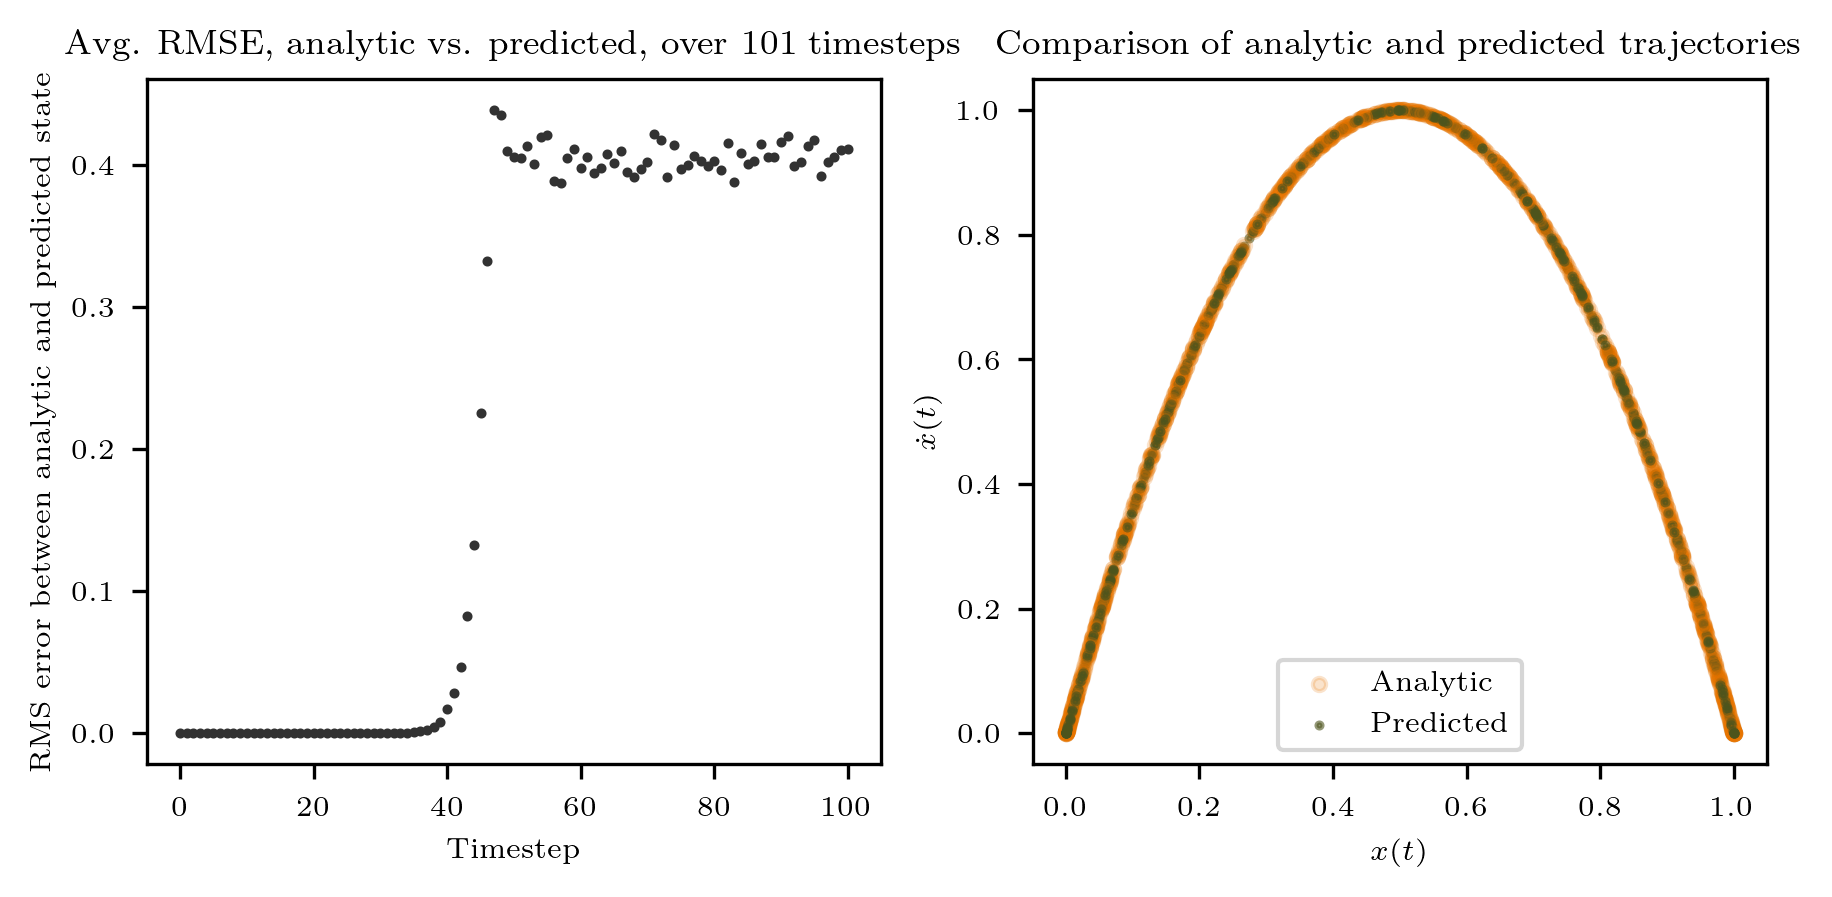

In [13]:
fig, ax = plt.subplots(1,2, figsize=(6,3))

# On the left, plot averaged prediction accuracy for each timestep. Does this approximation diverge?
ax[0].scatter(np.arange(0,len(eps),1), eps, s=2)
ax[0].set(xlabel="Timestep", ylabel="RMS error between analytic and predicted state")
ax[0].set_title(f"Avg. RMSE, analytic vs. predicted, over {m_test} timesteps")

# On the right, plot a couple of (corresponding) analytical and predicted trajectories over their time courses. How do they look?
num_plot = 10

# Set colors
pcycle = plt.rcParams['axes.prop_cycle']
colorwheel = [item['color'] for item in list(pcycle)]

for i in range(num_plot):
    randidx = np.random.randint(low = 0, high = m_traj_test)
    
    # I'm really only setting this logic flow to add the legend labels once. Otherwise code is same
    if i == 0:
        ax[1].scatter(X_test[0,:-1,randidx], X_test[0,1:,randidx], s=10, c=colorwheel[4], alpha=0.2, label="Analytic")
        ax[1].scatter(XK_test[0,:-1,randidx], XK_test[0,1:,randidx], s=2, c=colorwheel[2], alpha=0.6, label="Predicted")
    else:
        ax[1].scatter(X_test[0,:-1,randidx], X_test[0,1:,randidx], s=10, c=colorwheel[4], alpha=0.2)
        ax[1].scatter(XK_test[0,:-1,randidx], XK_test[0,1:,randidx], s=2, c=colorwheel[2], alpha=0.6)

ax[1].set(xlabel=r'$x(t)$', ylabel=r'$\dot{x}(t)$')
ax[1].set_title("Comparison of analytic and predicted trajectories")
ax[1].legend()
fig.tight_layout()

It is probably worthwhile to point out the interesting phase transition-like phenomenon occurring in the RMSE around timestep 40 of prediction. Seems robust to random initial conditions. Not sure why this would appear so sharp after a certain timestep, nor why this timestep in particular is where the error blows up, but I imagine this can be deduced by some mathematical property of the system, including our ICs.